In [1]:
from utils_ray import get_info_state, activate_memory_growth; activate_memory_growth(cpu=False)
import os, pickle
from datetime import datetime
import tensorflow as tf
import clubs
import clubs_gym
import gym
from jupyter_nb_utils import cumulative_reward, plot_results, live_plot
from PokerAgent import TensorflowAgent, Bet_Fct
from random import shuffle
import numpy as np
from utils_ray import print_obs
import time
from IPython.display import clear_output
from tqdm import trange

%matplotlib inline

[INFO] - Cannot activate memory growth, now this program uses all the available GPU memory.


In [2]:
# create result path
t_start = datetime.now()
datetime_str = t_start.strftime('%Y%m%d-%H%M%S')
results_dir = os.path.join('results_eval', datetime_str + '_evaluate-bot-action')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# INFO

With this Jupyter Notebook, you can <b>evaluate</b> your trained <b>strategy networks</b> and <b>advantage networks</b>.

# Create the Poker Environment

Set you preferred display style and choose whether to save the file.

<b>render_mode == 'WebBrowser'</b> <br>
You can watch the Poker Game within a web browser of your choice, additionally you will have live payoff statistics for the games played within the jupyter notebook. To have this featrue propperly working, you should use the club_gym env provided on its GitHub repo.<br>
-> Slow implementation: uses time.sleep() to slow down the game, to be able to follow the game plays

<b>render_mode == 'Terminal'</b> <br>
You can see the Poker Game within the Jupyter output (faster and better for evaluation of many games)

<b>render_mode == None</b> <br>
No display of the results during play.

<b>save_plot == True/False</b> <br>
To save or not save the plot to the results folder.

<b>eval_strategy_net == True/False</b> <br>
What kind of architecture you want to evaluate andvantage or strategy.

In [3]:
render_mode = "Terminal"
save_plot = True
eval_strategy_net = False

## Parameter settings for the Agents

In [4]:
# model paths
trained_model_path = 'trained_models/action_2_models/advantage-network_player-0_CRF-iteration-13'
random_model_path = 'trained_models/action_2_models/random_value_model'

# model type
model_output_types = ['action', 'action_2', 'bet']
model_type = model_output_types[1]
bet_fct = Bet_Fct(model_type)

# Agent used for sampling
agent_fct = TensorflowAgent

## Parameter settings for the poker (clubs_gym) environment

In [5]:
# Set game parameters
env_str = 'LDRL-Poker-v0'
num_players = 2
num_streets = 2
num_raises = 3
num_actions = 4
num_cards = [2, 3]
num_suits = 4
num_ranks = 13

# automatic setting of some params
n_community_cards = [0] + num_cards[1:]
n_cards_for_hand = min(5, sum(num_cards))
max_bet_number =  num_streets * (num_raises + ((num_players-1) * 2))

# environment params dict
config_dict = {'num_players': num_players,
               'num_streets': num_streets,
               'blinds': [1, 2],
               'antes': 0,
               'raise_sizes': 'pot',
               'num_raises': num_raises,
               'num_suits': num_suits,
               'num_ranks': num_ranks,
               'num_hole_cards': num_cards[0],
               'mandatory_num_hole_cards': 0,
               'num_community_cards': n_community_cards,
               'start_stack': 10_000_000,
               'num_cards_for_hand': n_cards_for_hand}

## Initialization of the Poker environment

In [6]:
clubs_gym.envs.register({env_str: config_dict})
env = gym.make(env_str)

# create new agents
if eval_strategy_net:
    # strategy network output are already the regret_matched advantage values
    env.register_agents([agent_fct(model_save_path, regr_matching=False)
                        for model_save_path in [trained_model_path, random_model_path]])
else:
    # advantage network output are the advantage values
    env.register_agents([agent_fct(model_save_path) for model_save_path in [
                        trained_model_path, random_model_path]])

# The Game traversal

In [7]:
# data logs
reward_history = None
action_history_p0 = []
action_history_p1 = []
preflop_history_p0 = []
preflop_history_p1 = []

In [8]:
sleep_time = 1
max_action = num_actions

if render_mode == 'WebBrowser':
    env.reset()
    env.render()

if render_mode is None:
    how_many_games = input(
        'Type in how many games should be used for ecaluation and hit enter to start. Games: ')
elif render_mode == 'WebBrowser':
    how_many_games = input(
        'Open the rendered Game (link above), input how many games you wanna see and hit Enter to start. Games: ')
elif render_mode == 'Terminal':
    how_many_games = input(
        'How many games do you wanna see? Hit enter to start. Games: ')
else:
    print(f'Render mode {render_mode}, not supported.')
    raise
    
for i in range(int(how_many_games)):
    obs = env.reset()
    counter = 1
    # display stuff
    if render_mode is None:
        pass
    elif render_mode == 'WebBrowser':
        env.render()
        time.sleep(sleep_time)
    else:
        print(f'\n====================== Game {i} ======================\n')
        print(f'Round: {counter}')
        print_obs(obs, num_suits)

    history = []
    while True:
        counter += 1
        
        if render_mode == 'WebBrowser':
            time.sleep(sleep_time)

        # non terminal-state
        if all(obs['active']) and not obs['action'] == -1:
            # 1.
            # agent chooses action based on info_state
            info_state = get_info_state(
                obs, history, max_bet_number, env.dealer.num_streets, config_dict)
            action_idx = env.act(info_state)

            # save bets for plots
            if obs['action'] == 0:
                action_history_p0.append(action_idx)
                if not obs['community_cards']:
                    preflop_history_p0.append(action_idx)
            else:
                action_history_p1.append(action_idx)
                if not obs['community_cards']:
                    preflop_history_p1.append(action_idx)

            # 2.
            # take action within environment
            bet = bet_fct(action_idx, obs)
            obs, rewards, done, _ = env.step(bet)
            history.append(bet)  # for info states

            # display stuff
            if render_mode is None:
                pass
            elif render_mode == 'WebBrowser':
                env.render()
            else:
                print(f'Action of the bot: {action_idx}')
                print(f'Bet: {bet}', end='\n\n')
                print('----------------------------------------------------\n')
                print(f'Round: {counter}')
                print_obs(obs, num_suits)

        # terminal state
        else:
            # save results
            if reward_history is None:
                reward_history = np.array([rewards])
            else:
                reward_history = np.append(reward_history, [rewards], axis=0)

            # display stuff
            if render_mode is None:
                if not i % (int(how_many_games)//10):
                    print(f'[INFO] - Finished traversals: {i}')
                
                if i == int(how_many_games)-1:
                    print(f'[INFO] - Done.')
            elif render_mode == 'WebBrowser':
                live_plot(reward_history, i)
            else:
                print(f'Payoffs: Player_0 {rewards[0]}, Player_1 {rewards[1]}')

            break

How many games do you wanna see? Hit enter to start. Games: 1000

====================== Game 0 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530608): 8♠, Card (139672807531232): 9♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 1 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531808): J♠, Card (139672807532240): Q

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 10 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807549248): 3♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549584): 4♠, Card (139672807532240): Q♥]
call: 0, min_raise: 2, max_raise:

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807533008): A♠, Card (139672807550448): 6♦, Card (139672807531568): T♥]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531472): T♠, Card (139672807532912): K♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807533008): A♠, Card (139672807550448): 6♦, Card (139672807531568): T♥]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 18 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, 

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531808): J♠, Card (139672807531664): T♦, Card (139672807531904): J♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550304): 6♠, Card (139672807532336): Q♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807531808): J♠, Card (139672807531664): T♦, Card (139672807531904): J♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531136): 9♥, Card (139672807533200): A♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

R

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530608): 8♠, Card (139672807549152): 3♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532336): Q♦, Card (139672807532480): Q♣, Card (139672807532144): Q♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530608): 8♠, Card (139672807549152): 3♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807550112): 5♦, Card (139672807531808): J♠, Card (139672807549920): 5♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 49 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531232): 9♦, Card (139672807548816): 6♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (1

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807530608): 8♠, Card (139672807550112): 5♦, Card (139672807530704): 8♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 59 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532480): Q♣, Card (139672807530800): 8♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

==========

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807550832): 7♦, Card (139672807533104): A♥, Card (139672807532144): Q♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 69 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532000): J♦, Card (139672807549056): 2♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

==========

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 82 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549440): 3♣, Card (139672807550544): 6♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549584): 4♠, Card (139672807550208): 5♣]
call: 0, min_raise: 2, max_raise:

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549248): 3♥, Card (139672807532240): Q♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 8
Commits: player_0 2, player_1 6

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807530704): 8♥]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807533200): A♦, Card (139672807532048): J♣]
De

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807531568): T♥, Card (139672807533200): A♦, Card (139672807532048): J♣]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807530608): 8♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531568): T♥, Card (139672807533200): A♦, Card (139672807532048): J♣]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530704): 8♥, Card (139672807530800): 8♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

R

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807530896): 8♣, Card (139672807549632): 4♥, Card (139672807531232): 9♦]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807550640): 7♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807530896): 8♣, Card (139672807549632): 4♥, Card (139672807531232): 9♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 112 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2,

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807550304): 6♠, Card (139672807549248): 3♥, Card (139672807531472): T♠]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532912): K♣, Card (139672807548720): 2♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807550304): 6♠, Card (139672807549248): 3♥, Card (139672807531472): T♠]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 122 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2,

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807548720): 2♠, Card (139672807533200): A♦, Card (139672807531040): 9♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531568): T♥, Card (139672807532336): Q♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807548720): 2♠, Card (139672807533200): A♦, Card (139672807531040): 9♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532672): K♥, Card (139672807549440): 3♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

R

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549728): 4♦, Card (139672807530800): 8♦, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549920): 5♠, Card (139672807530944): T♣]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807549728): 4♦, Card (139672807530800): 8♦, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 5, Player_1 -5

====================== Game 141 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807532912): K♣, Card (139672807531232): 9♦, Card (139672807548720): 2♠]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 150 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550448): 6♦, Card (139672807532480): Q♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531664): T♦, Card (139672807550304): 6♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532432): A♣, Card (139672807530896): 8♣, Card (139672807530704): 8♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531664): T♦, Card (139672807550304): 6♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807530896): 8♣, Card (139672807548864): 2♥]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531664): T♦, Card (139672807532816): K♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807530896): 8♣, Card (139672807548864): 2♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531232): 9♦, Card (139672807550304): 6♠]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------



Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531136): 9♥, Card (139672807531472): T♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807531664): T♦, Card (139672807550448): 6♦, Card (139672807532144): Q♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531136): 9♥, Card (139672807531472): T♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549728): 4♦, Card (139672807532672): K♥, Card (139672807550544): 6♣]
Dealer/Button: 0
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807550928): 7♣]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549728): 4♦, Card (139672807532672): K♥, Card (139672807550544): 6♣]
Dealer/Button: 0
Pot: 13
Commits: player_0 0, player_1 3

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532816): K♦, Card (139672807531568): T♥]
call: 3, min_raise: 6, max_raise: 19

Action of the bot: 0
Bet: 0

---------------------------------------------------

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807548720): 2♠, Card (139672807532336): Q♦, Card (139672807549728): 4♦]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550832): 7♦, Card (139672807549824): 4♣]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807548720): 2♠, Card (139672807532336): Q♦, Card (139672807549728): 4♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -5, Player_1 5

====================== Game 199 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807530800): 8♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532144): Q♠, Card (139672807531136): 9♥, Card (139672807531904): J♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807530800): 8♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 219 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807531568): T♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549728): 4♦, Card (139672807532000): J♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532048): J♣, Card (139672807531808): J♠

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807531040): 9♠, Card (139672807532048): J♣]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530944): T♣, Card (139672807531376): 9♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807531040): 9♠, Card (139672807532048): J♣]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531472): T♠, Card (139672807532576): K♠]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------



Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 8
Commits: player_0 2, player_1 6

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807532240): Q♥]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532576): K♠, Card (139672807549632): 4♥, Card (139672807530608): 8♠]
Dealer/Button: 0
Pot: 12
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549152): 3♠, Card (139672807532432): A♣]
call: 0, min_raise: 4, max_raise: 12

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807549632): 4♥, Card (139672807533104): A♥, Card (139672807549824): 4♣]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 243 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532912): K♣, Card (139672807530608): 8♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532144): Q♠, Card (139672807550928): 7♣, Card (139672807550304): 6♠]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532000): J♦, Card (139672807532048): J♣]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807532144): Q♠, Card (139672807550928): 7♣, Card (139672807550304): 6♠]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807550832): 7♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

R

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531472): T♠, Card (139672807549440): 3♣, Card (139672807533104): A♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531136): 9♥, Card (139672807550448): 6♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807531472): T♠, Card (139672807549440): 3♣, Card (139672807533104): A♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807532480): Q♣]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

R

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807530608): 8♠, Card (139672807532336): Q♦, Card (139672807531232): 9♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 265 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530896): 8♣, Card (139672807548864): 2♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 277 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530800): 8♦, Card (139672807550736): 7♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 7
Commits: player_0 5, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549584): 4♠, Card (139672807550832): 7♦]
call: 3, min_raise: 6, max_raise

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807550112): 5♦, Card (139672807549632): 4♥, Card (139672807550304): 6♠]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 286 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531376): 9♣, Card (139672807531664): T♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

=========

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807532336): Q♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549920): 5♠, Card (139672807532912): K♣, Card (139672807532432): A♣]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807532336): Q♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532144): Q♠, Card (139672807530800): 8♦, Card (139672807531808): J♠]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530608): 8♠, Card (139672807532336): Q♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532144): Q♠, Card (139672807530800): 8♦, Card (139672807531808): J♠]
Dealer/Button: 0
Pot: 6
Commits: player_0 0, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532816): K♦, Card (139672807548960): 2♦]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------



Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807550640): 7♠, Card (139672807532048): J♣, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 313 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549584): 4♠, Card (139672807550544): 6♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

=========

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807531376): 9♣, Card (139672807532480): Q♣, Card (139672807549248): 3♥]
Dealer/Button: 1
Pot: 6
Commits: player_0 0, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807549344): 3♦]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807531376): 9♣, Card (139672807532480): Q♣, Card (139672807549248): 3♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 323 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 332 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532480): Q♣, Card (139672807549344): 3♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530944): T♣, Card (139672807550016): 5♥]
call: 0, min_raise: 2, max_raise

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (139672807533008): A♠, Card (139672807549584): 4♠]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532672): K♥, Card (139672807532144): Q♠, Card (139672807531472): T♠]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807533008): A♠, Card (139672807549584): 4♠]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532240): Q♥, Card (139672807549920): 5♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807531904): J♥, Card (139672807549056): 2♣, Card (139672807550832): 7♦]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532240): Q♥, Card (139672807549920): 5♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531808): J♠, Card (139672807530800): 8♦]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532048): J♣, Card (139672807532336): Q♦, Card (139672807531232): 9♦]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531808): J♠, Card (139672807530800): 8♦]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532000): J♦, Card (139672807548864): 2♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549056): 2♣, Card (139672807550928): 7♣, Card (139672807548816): 6♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532000): J♦, Card (139672807548864): 2♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549632): 4♥, Card (139672807550304): 6♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532336): Q♦, Card (139672807550928): 7♣, Card (139672807550736): 7♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549632): 4♥, Card (139672807550304): 6♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807550832): 7♦, Card (139672807548864): 2♥, Card (139672807533008): A♠]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 390 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532048): J♣, Card (139672807532672): K♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807532480): Q♣, Card (139672807550112): 5♦, Card (139672807532000): J♦]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550832): 7♦, Card (139672807531664): T♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807532480): Q♣, Card (139672807550112): 5♦, Card (139672807532000): J♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 400 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2,

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807549584): 4♠, Card (139672807532144): Q♠, Card (139672807532432): A♣]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -5, Player_1 5

====================== Game 408 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531376): 9♣, Card (139672807531472): T♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807532672): K♥, Card (139672807530608): 8♠, Card (139672807531232): 9♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 417 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530608): 8♠, Card (139672807549824): 4♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 7
Commits: player_0 5, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807548864): 2♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532816): K♦, Card (139672807531664): T♦, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807548864): 2♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807531664): T♦]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532432): A♣, Card (139672807549632): 4♥, Card (139672807532816): K♦]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807531664): T♦]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807533104): A♥, Card (139672807549920): 5♠, Card (139672807531136): 9♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 441 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531808): J♠, Card (139672807532432): A♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532480): Q♣, Card (139672807532576): K♠, Card (139672807530704): 8♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531808): J♠, Card (139672807548960): 2♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532480): Q♣, Card (139672807532576): K♠, Card (139672807530704): 8♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807533200): A♦, Card (139672807549920): 5♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

R

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549824): 4♣, Card (139672807533200): A♦, Card (139672807549728): 4♦]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548864): 2♥, Card (139672807532576): K♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549824): 4♣, Card (139672807533200): A♦, Card (139672807549728): 4♦]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549920): 5♠, Card (139672807533104): A♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

R

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807550640): 7♠, Card (139672807550832): 7♦, Card (139672807550928): 7♣]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -5, Player_1 5

====================== Game 472 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530704): 8♥, Card (139672807550448): 6♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 481 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807530800): 8♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532144): Q♠, Card (139672807548816): 6♥]
call: 0, min_raise: 2, max_raise

Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532672): K♥, Card (139672807531040): 9♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 8
Commits: player_0 2, player_1 6

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532048): J♣, Card (139672807550736): 7♥]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531472): T♠, Card (139672807531376): 9♣, Card (139672807549920): 5♠]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 492 ======================

Round: 1
-------

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807548816): 6♥, Card (139672807531232): 9♦, Card (139672807533200): A♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 501 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807532576): K♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807531664): T♦, Card (139672807531376): 9♣, Card (139672807532240): Q♥]
Dealer/Button: 1
Pot: 14
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532432): A♣, Card (139672807548720): 2♠]
call: 4, min_raise: 8, max_raise: 22

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807531664): T♦, Card (139672807531376): 9♣, Card (139672807532240): Q♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -5, Player_1 5

====================== Game 509 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 517 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807533200): A♦, Card (139672807530704): 8♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807530608): 8♠]
call: 0, min_raise: 2, max_raise

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807550544): 6♣, Card (139672807550208): 5♣, Card (139672807531136): 9♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530800): 8♦, Card (139672807549632): 4♥]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807550544): 6♣, Card (139672807550208): 5♣, Card (139672807531136): 9♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530608): 8♠, Card (139672807532816): K♦]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 1
Bet: 0

----------------------------------------------------

R

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807548720): 2♠, Card (139672807531040): 9♠, Card (139672807532336): Q♦]
Dealer/Button: 0
Pot: 16
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532144): Q♠, Card (139672807532672): K♥]
call: 4, min_raise: 8, max_raise: 24

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807548720): 2♠, Card (139672807531040): 9♠, Card (139672807532336): Q♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 10, Player_1 -10

====================== Game 536 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531904): J♥, Card (139672807532672): K♥, Card (139672807550832): 7♦]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550544): 6♣, Card (139672807531808): J♠]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807531904): J♥, Card (139672807532672): K♥, Card (139672807550832): 7♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 546 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807531136): 9♥, Card (139672807532576): K♠]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549248): 3♥, Card (139672807548816): 6♥]
call: 0, min_raise: 2, max_raise: 8

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807548960): 2♦, Card (139672807531136): 9♥, Card (139672807532576): K♠]
Dealer/Button: 0
Pot: 10
Commits: player_0 0, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532432): A♣, Card (139672807550832): 7♦]
call: 2, min_raise: 4, max_raise: 14

Action of the bot: 0
Bet: 0

----------------------------------------------------


Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807530896): 8♣, Card (139672807549824): 4♣, Card (139672807549584): 4♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530704): 8♥, Card (139672807531040): 9♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807530896): 8♣, Card (139672807549824): 4♣, Card (139672807549584): 4♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 565 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1,

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807532672): K♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 8
Commits: player_0 2, player_1 6

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550832): 7♦, Card (139672807531808): J♠]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532816): K♦, Card (139672807548960): 2♦, Card (139672807550448): 6♦]
De

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531136): 9♥, Card (139672807549440): 3♣, Card (139672807531568): T♥]
Dealer/Button: 0
Pot: 6
Commits: player_0 0, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549584): 4♠, Card (139672807532672): K♥]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807531136): 9♥, Card (139672807549440): 3♣, Card (139672807531568): T♥]
Dealer/Button: 0
Pot: 10
Commits: player_0 4, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532240): Q♥, Card (139672807532336): Q♦]
call: 2, min_raise: 4, max_raise: 14

Action of the bot: 3
Bet: 4

----------------------------------------------------

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 591 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530896): 8♣, Card (139672807550304): 6♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 592 ======================

Round: 1
------------------- game S

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532000): J♦, Card (139672807530896): 8♣]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807531664): T♦, Card (139672807531808): J♠, Card (139672807531136): 9♥]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532000): J♦, Card (139672807530896): 8♣]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807550304): 6♠, Card (139672807550208): 5♣, Card (139672807548816): 6♥]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807548960): 2♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807550304): 6♠, Card (139672807550208): 5♣, Card (139672807548816): 6♥]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532144): Q♠, Card (139672807550928): 7♣]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 0
Bet: 0

----------------------------------------------------



Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532336): Q♦, Card (139672807549056): 2♣, Card (139672807531568): T♥]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550208): 5♣, Card (139672807549152): 3♠]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807532336): Q♦, Card (139672807549056): 2♣, Card (139672807531568): T♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 5, Player_1 -5

====================== Game 619 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807548864): 2♥, Card (139672807532480): Q♣, Card (139672807549056): 2♣]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 8, Player_1 -8

====================== Game 627 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550208): 5♣, Card (139672807531376): 9♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807532144): Q♠, Card (139672807550736): 7♥, Card (139672807549056): 2♣]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -6, Player_1 6

====================== Game 636 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807532816): K♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 647 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548816): 6♥, Card (139672807549152): 3♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 648 ======================

Round: 1
------------------- game S

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807550448): 6♦, Card (139672807531232): 9♦, Card (139672807531808): J♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 655 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531232): 9♦, Card (139672807550448): 6♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532048): J♣, Card (139672807531376): 9♣, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807533200): A♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532048): J♣, Card (139672807531376): 9♣, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807533008): A♠, Card (139672807549728): 4♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

R

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807530944): T♣, Card (139672807532816): K♦, Card (139672807531568): T♥]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 674 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532336): Q♦, Card (139672807530944): T♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

=========

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532048): J♣, Card (139672807533104): A♥, Card (139672807550832): 7♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 683 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807549920): 5♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 7
Commits: player_0 5, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549344): 3♦, Card (139672807530608): 8♠, Card (139672807532240): Q♥]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 692 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550928): 7♣, Card (139672807530800): 8♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550640): 7♠, Card (139672807549344): 3♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 6
Commits: player_0 2, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532816): K♦, Card (139672807550016): 5♥]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549584): 4♠, Card (139672807550832): 7♦, Card (139672807532336): Q♦]
De

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807531568): T♥, Card (139672807532048): J♣, Card (139672807550928): 7♣]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 709 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807532912): K♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530704): 8♥, Card (1

Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807532912): K♣, Card (139672807530944): T♣, Card (139672807549440): 3♣]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 719 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807532912): K♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531472): T♠,

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807531472): T♠, Card (139672807548960): 2♦, Card (139672807550448): 6♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -4, Player_1 4

====================== Game 728 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550016): 5♥, Card (139672807549248): 3♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549728): 4♦, Card (139672807550736): 7♥, Card (139672807531040): 9♠]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807533104): A♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549728): 4♦, Card (139672807550736): 7♥, Card (139672807531040): 9♠]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532048): J♣, Card (139672807530896): 8♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

R

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532576): K♠, Card (139672807532816): K♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 6
Commits: player_0 2, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530704): 8♥, Card (139672807531136): 9♥]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807530800): 8♦, Card (139672807532240): Q♥, Card (139672807532000): J♦]
De

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549056): 2♣, Card (139672807531376): 9♣, Card (139672807532480): Q♣]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530944): T♣, Card (139672807532240): Q♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807549056): 2♣, Card (139672807531376): 9♣, Card (139672807532480): Q♣]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 758 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2,

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807531472): T♠, Card (139672807548864): 2♥, Card (139672807550832): 7♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 765 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549344): 3♦, Card (139672807531664): T♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807532432): A♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807550304): 6♠, Card (139672807550640): 7♠, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807549824): 4♣, Card (139672807532432): A♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807532336): Q♦, Card (139672807549824): 4♣, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 6
Commits: player_0 0, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807533104): A♥]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807532336): Q♦, Card (139672807549824): 4♣, Card (139672807548720): 2♠]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 781 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1


====================== Game 789 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548864): 2♥, Card (139672807549920): 5♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 790 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550928): 7♣, Card (139672807531472): T♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 3


Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532672): K♥, Card (139672807549584): 4♠, Card (139672807549920): 5♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532432): A♣, Card (139672807531040): 9♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532672): K♥, Card (139672807549584): 4♠, Card (139672807549920): 5♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550544): 6♣, Card (139672807550736): 7♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

R

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807530944): T♣]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807530800): 8♦, Card (139672807533008): A♠, Card (139672807532240): Q♥]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807530944): T♣]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549728): 4♦, Card (139672807549440): 3♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532672): K♥, Card (139672807532576): K♠, Card (139672807549632): 4♥]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549728): 4♦, Card (139672807549440): 3♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

====================== Game 830 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807531904): J♥, Card (139672807550736): 7♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 0
Commits: player_0 2, player_1 1

[INFO] - End of the Game.
Payoffs: Player_0 1, Player_1 -1

====================== Game 831 ======================

Round: 1
------------------- game S

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807531664): T♦, Card (139672807531904): J♥, Card (139672807548816): 6♥]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548864): 2♥, Card (139672807530608): 8♠]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531664): T♦, Card (139672807531904): J♥, Card (139672807548816): 6♥]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807549440): 3♣, Card (139672807533200): A♦]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

---------------------------------------------------

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807531904): J♥, Card (139672807531568): T♥, Card (139672807532048): J♣]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550928): 7♣, Card (139672807550640): 7♠]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807531904): J♥, Card (139672807531568): T♥, Card (139672807532048): J♣]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807550304): 6♠]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 2
Bet: 2

---------------------------------------------------

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532816): K♦, Card (139672807532432): A♣, Card (139672807532480): Q♣]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550640): 7♠, Card (139672807550016): 5♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532816): K♦, Card (139672807532432): A♣, Card (139672807532480): Q♣]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807533200): A♦, Card (139672807532912): K♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

R

Action of the bot: 1
Bet: 2

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807548864): 2♥, Card (139672807550016): 5♥, Card (139672807549632): 4♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 4, Player_1 -4

====================== Game 871 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548720): 2♠, Card (139672807532000): J♦]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 0
Commits: player_0 1, player_1 2

[INFO] - End of the Game.
Payoffs: Player_0 -1, Player_1 1

=========

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532480): Q♣, Card (139672807548720): 2♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549248): 3♥, Card (139672807549584): 4♠, Card (139672807550736): 7♥]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807532480): Q♣, Card (139672807548720): 2♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807549920): 5♠, Card (139672807550112): 5♦, Card (139672807532240): Q♥]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 896 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2, player_1 1

---------------- player 1's turn ----------------
hole_cards: [Card (139672807548864): 2♥, Card (139672807532432): A♣]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (

Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807532576): K♠, Card (139672807531808): J♠, Card (139672807550640): 7♠]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807530800): 8♦, Card (139672807549920): 5♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807532576): K♠, Card (139672807531808): J♠, Card (139672807550640): 7♠]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531472): T♠, Card (139672807549632): 4♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 5
-------------

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807530896): 8♣, Card (139672807532336): Q♦, Card (139672807532816): K♦]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807550208): 5♣, Card (139672807532048): J♣]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807530896): 8♣, Card (139672807532336): Q♦, Card (139672807532816): K♦]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807548960): 2♦, Card (139672807533104): A♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

R

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807550208): 5♣, Card (139672807532000): J♦, Card (139672807548960): 2♦]
Dealer/Button: 0
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550736): 7♥, Card (139672807532672): K♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807550208): 5♣, Card (139672807532000): J♦, Card (139672807548960): 2♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 2, Player_1 -2

====================== Game 920 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2,

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549248): 3♥, Card (139672807531040): 9♠, Card (139672807532144): Q♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807533200): A♦, Card (139672807532336): Q♦]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549248): 3♥, Card (139672807531040): 9♠, Card (139672807532144): Q♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 1's turn ----------------
hole_cards: [Card (139672807548960): 2♦, Card (139672807530704): 8♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

R

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807530800): 8♦, Card (139672807548720): 2♠, Card (139672807548960): 2♦]
Dealer/Button: 0
Pot: 8
Commits: player_0 0, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550928): 7♣, Card (139672807550640): 7♠]
call: 4, min_raise: 8, max_raise: 16

Action of the bot: 1
Bet: 4

----------------------------------------------------

Round: 5
------------------- game Stats -------------------
community_cards: [Card (139672807530800): 8♦, Card (139672807548720): 2♠, Card (139672807548960): 2♦]
Dealer/Button: 0
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 6, Player_1 -6

====================== Game 938 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 3
Commits: player_0 2

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807549056): 2♣, Card (139672807531904): J♥, Card (139672807530800): 8♦]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 947 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531232): 9♦, Card (139672807549584): 4♠]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807532672): K♥, Card (139672807549632): 4♥]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 6
Commits: player_0 2, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531472): T♠, Card (139672807532336): Q♦]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807550736): 7♥, Card (139672807550544): 6♣, Card (139672807533008): A♠]
De

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (139672807533008): A♠, Card (139672807548720): 2♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 6
Commits: player_0 2, player_1 4

---------------- player 0's turn ----------------
hole_cards: [Card (139672807530944): T♣, Card (139672807550208): 5♣]
call: 2, min_raise: 4, max_raise: 10

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card (139672807549584): 4♠, Card (139672807532432): A♣, Card (139672807533104): A♥]
De

Action of the bot: 1
Bet: 1

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531232): 9♦, Card (139672807533008): A♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807530800): 8♦, Card (139672807550304): 6♠, Card (139672807550640): 7♠]
Dealer/Button: 1
Pot: 4
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531232): 9♦, Card (139672807533008): A♠]
call: 0, min_raise: 2, max_raise: 4

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Card 

Action of the bot: 0
Bet: 0

----------------------------------------------------

Round: 6
------------------- game Stats -------------------
community_cards: [Card (139672807533008): A♠, Card (139672807531136): 9♥, Card (139672807530704): 8♥]
Dealer/Button: 1
Pot: 0
Commits: player_0 0, player_1 0

[INFO] - End of the Game.
Payoffs: Player_0 -2, Player_1 2

====================== Game 983 ======================

Round: 1
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 3
Commits: player_0 1, player_1 2

---------------- player 0's turn ----------------
hole_cards: [Card (139672807531568): T♥, Card (139672807549632): 4♥]
call: 1, min_raise: 3, max_raise: 5

Action of the bot: 2
Bet: 2

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 0
Pot: 4
Commits: player_0 2, player_1 2

---------------- player 1's turn ----------------
hole_cards: [Card (

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 2
------------------- game Stats -------------------
community_cards: []
Dealer/Button: 1
Pot: 7
Commits: player_0 2, player_1 5

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550208): 5♣, Card (139672807533200): A♦]
call: 3, min_raise: 6, max_raise: 13

Action of the bot: 3
Bet: 4

----------------------------------------------------

Round: 3
------------------- game Stats -------------------
community_cards: [Card (139672807530800): 8♦, Card (139672807532672): K♥, Card (139672807548864): 2♥]
Dealer/Button: 1
Pot: 10
Commits: player_0 0, player_1 0

---------------- player 0's turn ----------------
hole_cards: [Card (139672807550208): 5♣, Card (139672807533200): A♦]
call: 0, min_raise: 3, max_raise: 10

Action of the bot: 1
Bet: 0

----------------------------------------------------

Round: 4
------------------- game Stats -------------------
community_cards: [Ca

In [9]:
# save experiment data
exp_data = {'reward_history': reward_history,
            'action_history_p0': action_history_p0,
            'action_history_p1': action_history_p1,
            'preflop_history_p0': preflop_history_p0,
            'preflop_history_p1': preflop_history_p1}

fn_exp_data = os.path.join(results_dir, f"{trained_model_path.split('/')[-1]}_lossData.pkl")

with open(fn_exp_data, 'wb') as f:
    pickle.dump(exp_data, f)

# Evaluate the Poker Game

Player 0 is the player (agent) that has the trained model.

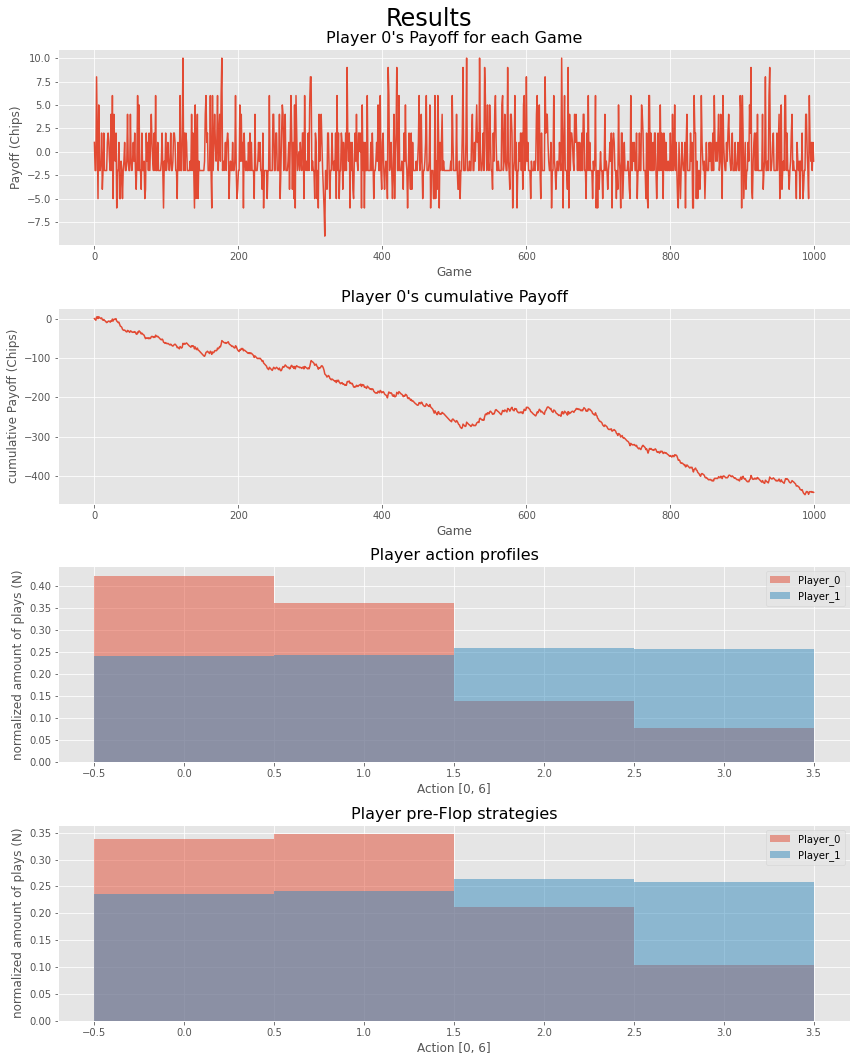

In [10]:
if save_plot:
    fn = 'game_results.svg'
save_path = os.path.join(results_dir, fn)

# create plot
plot_results(reward_history, num_actions, action_history_p0,
             action_history_p1, preflop_history_p0, preflop_history_p1, save_path)

In [11]:
np.std(reward_history)

3.1761612049768506